In [1]:
# Reload when code changed:
%load_ext autoreload
%autoreload 2
%pwd
import sys
import os
path = "../"
sys.path.append(path)
#os.path.abspath("../")
print(os.path.abspath(path))

D:\Utveckling\git\ekostat_calculator


In [2]:
import os 
import core
import importlib
importlib.reload(core) 
try:
    logging.shutdown()
    importlib.reload(logging)
except:
    pass
import pandas as pd
import numpy as np
import json
import time

from event_handler import EventHandler
print(core.__file__)
pd.__version__

..\core\__init__.py


'0.19.2'

In [3]:
t0 = time.time()

print(time.time() - t0)

0.0


In [4]:
def get_integrated_mean(depth_list, 
                        value_list, 
                        depth_interval):
    
    depth_list = list(depth_list)
    value_list = list(value_list)
    sum_list = []
    # Make sure to integrate the whole surface layer if selected
    if depth_list[0] != depth_interval[0]:
        depth_list.insert(0, depth_interval[0])
        value_list.insert(0, value_list[0])
    if depth_list[-1] != depth_interval[-1]:
        depth_list.append(depth_interval[-1])
        value_list.append(value_list[-1])

    for z0, z1, v0, v1 in zip(depth_list[:-1], depth_list[1:], 
                              value_list[:-1], value_list[1:]):

        part_sum = 0.5*(v1+v0)*(z1-z0)

        sum_list.append(part_sum)

    return sum(sum_list)/(depth_list[-1]-depth_list[0])

In [5]:
def get_integrated_mean_alt(depth_list, 
                        value_list, 
                        depth_interval):
    
    sum_list = []
    # Make sure to integrate the whole surface layer if selected
    if depth_list[0] != depth_interval[0]:
        depth_list = np.insert(depth_list, depth_interval[0])
        value_list = np.insert(value_list, value_list[0])
    if depth_list[-1] != depth_interval[-1]:
        depth_list = np.append(depth_list, depth_interval[-1])
        value_list = np.append(value_list, value_list[-1])
    
    sum_list = np.sum(0.5*(value_list[1:]+value_list[:-1])*(depth_list[1:]-depth_list[:-1]))

    return sum_list/(depth_list[-1]-depth_list[0])

In [6]:
nr = 100000

depth_list = np.array([0, 5, 10, 15])
value_list = np.array([1.2, 4.3, 5.3, 1.3]) 
depth_interval = np.array([0, 5, 10, 15])

t0 = time.time()
list_1 = []
for k in range(nr): 
    list_1.append(get_integrated_mean(depth_list, 
                                      value_list, 
                                      depth_interval))
print(time.time() - t0) 

t0 = time.time()
list_2 = []
for k in range(nr): 
    list_2.append(get_integrated_mean_alt(depth_list, 
                                          value_list, 
                                          depth_interval))
print(time.time() - t0)

print(sum(list_1))
print(sum(list_2))

1.0109999179840088
1.4609999656677246
361666.666666
361666.666666


In [98]:
def get_exclude_index_array(df): 
    exclude_list = []
    for col in df.columns:
        if 'Q_' in col:
            exclude_list.append(col[2:])
            exclude_list.append(col)
        elif 'source' in col:
            exclude_list.append(col) 
            
    exclude_index_list = [True if par in exclude_list else False for par in df.columns]
    return np.array(exclude_index_list)

In [99]:
def calculate(df):
    
    if len(df) < min_nr_values:
        #print(len(df))
        return False
    # Extrac data lists
    depth_list = list(df['DEPH'].values) 
    value_list = list(df[use_par].values) 
    
    t_calc_integ = time.time()
    mean_value = get_integrated_mean(depth_list, 
                                     value_list, 
                                     depth_interval)
    time_list_calc_integ.append(time.time() - t_calc_integ)
    
    t_add_row = time.time()
    # Add info to row
    new_row_series = df.loc[df.index[0], :].copy(deep=True)
    new_row_series[new_par] = mean_value
    new_row_series[new_par_depths] = ';'.join(map(str, depth_list))
    new_row_series[new_par_values] = ';'.join(map(str, value_list))
    new_row_series['MNDEP'] = depth_interval[0]
    new_row_series['MXDEP'] = depth_interval[1]
    #print('df.columns', len(df.columns))
    #print(df.columns)
    new_row = np.array(new_row_series)
    new_row[exclude_index_array] = np.nan

    new_list_to_append.append(list(new_row)) 
    time_list_add_row.append(time.time() - t_add_row)
    
    return True

In [100]:
use_par = 'CPHL_BTL'
new_par = 'CHPL_INTEG_CALC' 
new_par_depths = new_par + '_depths'
new_par_values = new_par + '_values' 
depth_interval = [0, 10]
min_nr_values = 2



### Method 1

In [101]:
all_data = pd.read_csv('all_data.txt', sep='\t', encoding='cp1252') 

new_list_to_append = [] # list of lists with the new rows to be added to all_data once all calculations are done
# new_df = pd.DataFrame(columns=all_data.columns)

time_list_group_data = []
time_list_calc_integ = []
time_list_add_row = [] 



t_tot = time.time()
t_preparations = time.time()
# Add result columns
all_data[new_par] = np.nan 
all_data[new_par_depths] = np.nan
all_data[new_par_values] = np.nan
# Temp 
all_data['MNDEP'] = np.nan
all_data['MXDEP'] = np.nan


exclude_index_array = get_exclude_index_array(all_data) 
# print(len(exclude_index_array))
# print(len(all_data.columns))

# Narrow the data to only include lines where par is present and depth is in range
use_par_boolean = ~all_data[use_par].isnull() 
depth_boolean = (all_data['DEPH'] >= depth_interval[0]) & \
                (all_data['DEPH'] <= depth_interval[1]) 
    
active_boolean = use_par_boolean & depth_boolean
time_preparations = time.time() - t_preparations


t_group_data = time.time()
grouped_data = all_data.loc[active_boolean, :].groupby('visit_id_str')
time_list_group_data.append(time.time() - t_group_data)

t_iterator = time.time()
calculations = (calculate(group) for visit_id, group in grouped_data)
time_iterator = time.time() - t_iterator

t_all_calculation = time.time()
result = list(calculations)
time_all_calculation = time.time() - t_all_calculation
time_total = time.time() - t_tot

print('-'*50)
print('Total time:', time_total)
print('time_preparations'.ljust(30), time_preparations)
print('time_list_group_data:'.ljust(30), sum(time_list_group_data))
print('time_list_calc_integ:'.ljust(30), sum(time_list_calc_integ))
print('time_list_add_row:'.ljust(30), sum(time_list_add_row)) 
print('time_all_calculations:'.ljust(30), time_all_calculation)
print('time_iterator:'.ljust(30), time_iterator)



--------------------------------------------------
Total time: 6.063153505325317
time_preparations              0.009999752044677734
time_list_group_data:          0.040000200271606445
time_list_calc_integ:          0.09000134468078613
time_list_add_row:             2.780073404312134
time_all_calculations:         6.013153553009033
time_iterator:                 0.0


In [107]:
print(len(new_list_to_append))
print(len(all_data))
updated_all_data = all_data.copy(deep=True)
print(len(updated_all_data))
add_lines_df = pd.DataFrame(new_list_to_append, columns=all_data.columns)
updated_all_data = updated_all_data.append(add_lines_df)
print(len(updated_all_data))
print(len(all_data))
updated_all_data.to_csv('export_all_data.txt', sep='\t', encoding='cp1252')

4624
86545
86545
91169
86545


### Calculate halocline 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
all_data = pd.read_csv('all_data.txt', sep='\t', encoding='cp1252')

In [3]:
visit_list = list(set(all_data['visit_id_str']))
index = 0
for index in range(0, len(all_data)):
    visit_boolean = all_data['visit_id_str'] == visit_list[index]
    df = all_data.loc[visit_boolean, ['DEPH', 'SALT']].copy(deep=True)
    if max(df['DEPH']) > 100:
        break

        DEPH    SALT  DEPH_neg
63731    0.0  25.547      -0.0
63732    2.0  25.588      -2.0
63733    5.0  26.339      -5.0
63734   10.0  29.069     -10.0
63735   15.0  30.550     -15.0
63736   20.0  31.134     -20.0
63737   30.0  32.050     -30.0
63738  244.0  34.849    -244.0


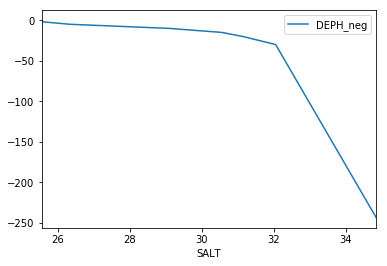

In [4]:
df['DEPH_neg'] = -df['DEPH']
print(df)
df[['DEPH_neg', 'SALT']].plot(x='SALT', y='DEPH_neg')

In [5]:
depth = df['DEPH']
salt = df['SALT']

df['DEPH_diff'] = df['DEPH'].diff()
df['SALT_diff'] = df['SALT'].diff()

df['derivative'] = df['SALT_diff'].divide(df['DEPH_diff'])

df = df.loc[df['DEPH']>5, :].copy(deep=True)

In [6]:
print(df)

        DEPH    SALT  DEPH_neg  DEPH_diff  SALT_diff  derivative
63734   10.0  29.069     -10.0        5.0      2.730    0.546000
63735   15.0  30.550     -15.0        5.0      1.481    0.296200
63736   20.0  31.134     -20.0        5.0      0.584    0.116800
63737   30.0  32.050     -30.0       10.0      0.916    0.091600
63738  244.0  34.849    -244.0      214.0      2.799    0.013079


In [16]:
df['temp'] = [1,0,1,1,1]
all(df['temp'])

False

In [18]:
list(df['temp'])

[1, 0, 1, 1, 1]

In [3]:
df = pd.DataFrame(columns=['a', 'b', 'c'])

In [6]:
df.loc[0,:] = [1, 2, 3]

In [7]:
df

,a,b,c
0,1,2,3
